In [1]:
import glob, json, os
import torch
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
from PIL import Image
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob(
    './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg'
)

img_paths = img_paths[:10]
img_paths

['./data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/081337fe35edefde84f5717001e31ea96a3a6dfb.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/263362f3df3daf85ccec9c8519a07cbf97f2264c.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/d0a7f41c85726752594a8adb9fde8362d50b6893.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/5aa0ab14a4fb9573744f60330281cdfde0dc3977.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/32b66df75ef394c08b364468e7803a3e218d90f6.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/7430a045f9d01e9c246452fb2d18d7ada0cb14f7.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/c06ba4aa5cbc94a7488219aad2a73499144961e6.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation

In [2]:
validation_annotations = json.load(open('./data/ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json'))

validation_annotations[:10]

[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']},
 {'url': 'http://img3.cache.netease.com/photo/0005/2011-09-23/7EJKTMHN00D80005.jpg',
  'image_id': 'b573129c61c37aced9c1ede434ec150cbcfdfac5.jpg',
  'caption': ['一个穿着运动服的男人单膝跪在球场上',
   '一个穿着运动服的运动员单膝跪在运动场上',
   '一个穿着运动服的男人摔倒在宽阔的运动场上',
   '一个穿着短袖上衣的男人跪在运动场上',
   '一个穿着白色上衣的男人单膝跪在足球场上']},
 {'url': 'http://imgsrc.baidu.com/imgad/pic/item/728da9773912b31b1ce1ab018c18367adab4e10d.jpg',
  'image_id': 'be6a5

In [3]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}
validation_annotations_dict

{'3cd32bef87ed98572bac868418521852ac3f6a70.jpg': '一个双臂抬起的运动员跪在绿茵茵的球场上',
 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg': '房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
 'b573129c61c37aced9c1ede434ec150cbcfdfac5.jpg': '一个穿着运动服的男人单膝跪在球场上',
 'be6a53a8f61e2fc7d6b7236f6e497be044c6f37e.jpg': '湍急的河水里有一群穿着救生衣的人在划橡皮艇',
 'b0aaa3680cb21d48500bbd51f033d244993b5791.jpg': '办公室里有三个穿着衬衫的人在讨论事情',
 '97d3a1f7bcbc70d6c6e866bd891b3a5287da093f.jpg': '一个戴着墨镜的男人牵着一个穿着白色裙子的女人走在道路上',
 'e57164644c7b0ecf71809367b71889c00066a2c9.jpg': '一个背着包的女人走在人来人往的街道上',
 '938ae3e544106af9e9d5c7dc55bfa7fd003a787d.jpg': '一个围着围巾的女人和一个穿着深色衣服的男人走在人来人往的道路上',
 'bd58fd0ad0c55f4f2eec93658b0a989021b3b2e4.jpg': '展板前的桌子前一个戴着眼镜的男人旁有一个双手相握的男人在讲话',
 'a20401efd162bd6320a2203057019afbf996423c.jpg': '一个穿着深色上衣的男人和一个双手拿着牌子的男人站在广告牌前',
 '0b99c786609b5a5ba8bf1a229eca6529352ef53c.jpg': '一个穿着浅色短裤的女人在球场上跳舞',
 '953c8557e97575eb50ce93aa6f6aff7fde3b622e.jpg': '一个穿着牛仔裤的女人挽着一个男人站在干净的屋子里',
 '89afc875ebfe96d29b8e7a331baf24b6af44ef35.jpg': '院子里有一群围着桌子坐的人在野炊',
 '546d1e601125e

In [4]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_paths_basenames

['081337fe35edefde84f5717001e31ea96a3a6dfb.jpg',
 '263362f3df3daf85ccec9c8519a07cbf97f2264c.jpg',
 'd0a7f41c85726752594a8adb9fde8362d50b6893.jpg',
 '5aa0ab14a4fb9573744f60330281cdfde0dc3977.jpg',
 '32b66df75ef394c08b364468e7803a3e218d90f6.jpg',
 '7430a045f9d01e9c246452fb2d18d7ada0cb14f7.jpg',
 'c06ba4aa5cbc94a7488219aad2a73499144961e6.jpg',
 '81e541953ee9d3a52834968c40f871cb51dd5caf.jpg',
 '7055f2d552eb4e4c4063824ef41892285da2c57b.jpg',
 '0351821cc391b30f7f6e6c7e4075b5285a63ab6f.jpg']

In [5]:
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]
img_captions

['绿茵茵的足球场上一个跑着的人旁边有两个穿着不同球衣的男人在抢球',
 '两个低着头看手机的女人行走在干净明亮的大厅里',
 '房间里的四个人旁边有一个拿着相机的男人在给一个身穿短袖的男人拍照',
 '球场上一群人中间一个侧卧着的人旁坐着一个双手握拳的男人',
 '房屋里有四个穿着深色上衣的男人在打牌',
 '房间里站着两个一起抓着牌子的男人',
 '房子里有一个抬起右手的小孩在亲吻一个穿着短袖的小孩',
 '三个穿着深色上衣的人在健身房里健身',
 '室内的柱子旁一个手拿东西的男人在采访一个戴眼镜的女人',
 '大厅里一群人的旁边有两个戴着眼镜的男人在握手']

In [6]:
img_captions[0]

'绿茵茵的足球场上一个跑着的人旁边有两个穿着不同球衣的男人在抢球'

In [7]:
model = ChineseCLIPModel.from_pretrained("../../models/chinese-clip-vit-base-patch16")
processor = ChineseCLIPProcessor.from_pretrained("../../models/chinese-clip-vit-base-patch16")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
img_image_feat = []

imgs = [Image.open(path) for path in img_paths]

inputs = processor(images=imgs, return_tensors="pt")

with torch.no_grad():
    image_features = model.get_image_features(**inputs)
    img_image_feat = image_features.data.numpy()

img_image_feat = normalize(img_image_feat)

In [9]:
img_image_feat.shape

(10, 512)

In [10]:
img_text_feat = []

inputs = processor(text=img_captions, return_tensors="pt", padding=True)

with torch.no_grad():
    text_features = model.get_text_features(**inputs)
    img_text_feat = image_features.data.numpy()

img_text_feat = normalize(img_text_feat)

In [11]:
idx = 6
sim_result = np.dot(img_text_feat[idx], img_image_feat.T)
sim_idx = sim_result.argsort()[::-1][0:3]
sim_idx

array([6, 9, 4])

输入文本:  房子里有一个抬起右手的小孩在亲吻一个穿着短袖的小孩


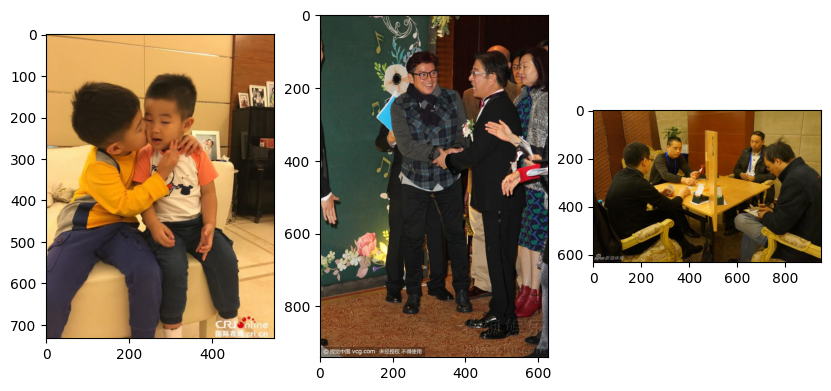

In [12]:
print('输入文本: ', img_captions[idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))

In [13]:
idx = 8
sim_result = np.dot(img_image_feat[idx], img_text_feat.T)
sim_idx = sim_result.argsort()[::-1][0:3]
sim_idx

array([8, 4, 9])

['室内的柱子旁一个手拿东西的男人在采访一个戴眼镜的女人', '房屋里有四个穿着深色上衣的男人在打牌', '大厅里一群人的旁边有两个戴着眼镜的男人在握手']

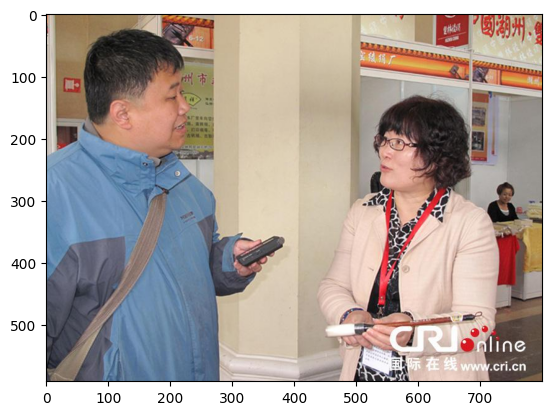

In [14]:
plt.imshow(Image.open(img_paths[sim_idx[0]]))
result = [img_captions[x] for x in sim_idx]
result